In [50]:
import os

# os.environ["CASTLE_BACKEND"] = "pytorch"
# from castle.common import GraphDAG, priori_knowledge
# from castle.metrics import MetricsDAG
# from castle.algorithms import PC
from dagma.linear import DagmaLinear
import pandas as pd
import numpy as np

df = pd.read_csv("dataset.csv")
names = df.columns.to_list()[1:]
data = df.to_numpy()[:, 1:]
data /= data.std(axis=0).reshape(1, -1)

In [51]:
print(names)
print(data.shape)
print(data[:4])

['Mood-0', 'Energy-0', 'Deep_work-0', 'Stoicism-0', 'Optimization_power-0', 'Sleep-0', 'Meditation-0', 'Sport-0', 'Social_interactions-0', 'Mood-1', 'Energy-1', 'Deep_work-1', 'Stoicism-1', 'Optimization_power-1', 'Sleep-1', 'Meditation-1', 'Sport-1', 'Social_interactions-1', 'Mood-2', 'Energy-2', 'Deep_work-2', 'Stoicism-2', 'Optimization_power-2', 'Sleep-2', 'Meditation-2', 'Sport-2', 'Social_interactions-2']
(103, 27)


In [69]:
# prior = priori_knowledge.PrioriKnowledge(len(names))
exclude_edges = []
for i in range(len(names)):
    for j in range(len(names)):
        if names[i][-1] < names[j][-1]:
            exclude_edges.append((i, j))
solver = DagmaLinear(loss_type="l2", verbose=False, dtype=np.float64)
adj_matrix = solver.fit(data, T=8, exclude_edges=exclude_edges)

  0%|          | 0/270000.0 [00:00<?, ?it/s]

('Deep_work-0', 'Meditation-0', 1.5705546622805275)
('Deep_work-0', 'Sport-0', 1.4948514122118441)
('Deep_work-1', 'Deep_work-0', 0.39120795775230666)
('Deep_work-1', 'Meditation-0', -1.031201707520009)
('Deep_work-1', 'Sport-0', -1.001532785751085)
('Deep_work-2', 'Meditation-0', 1.3011291840754793)
('Energy-0', 'Meditation-0', 1.0672091253886828)
('Energy-0', 'Sport-0', 11.021632304146264)
('Energy-1', 'Deep_work-0', 0.36617824248789216)
('Energy-1', 'Meditation-0', 1.1016466294474392)
('Energy-1', 'Sport-0', -0.40972055195631657)
('Energy-2', 'Meditation-0', -2.903181743843734)
('Energy-2', 'Sport-0', 2.345579009457387)
('Energy-2', 'Stoicism-0', -0.565472586414775)
('Meditation-2', 'Sport-0', -0.6009008029789044)
('Mood-0', 'Deep_work-0', -0.6107152239764695)
('Mood-0', 'Meditation-0', -2.8420901913859447)
('Mood-0', 'Social_interactions-0', -0.4607853746033707)
('Mood-0', 'Sport-0', -2.17440009344419)
('Mood-0', 'Stoicism-0', -0.4742485324240161)
('Mood-1', 'Meditation-0', -1.0843

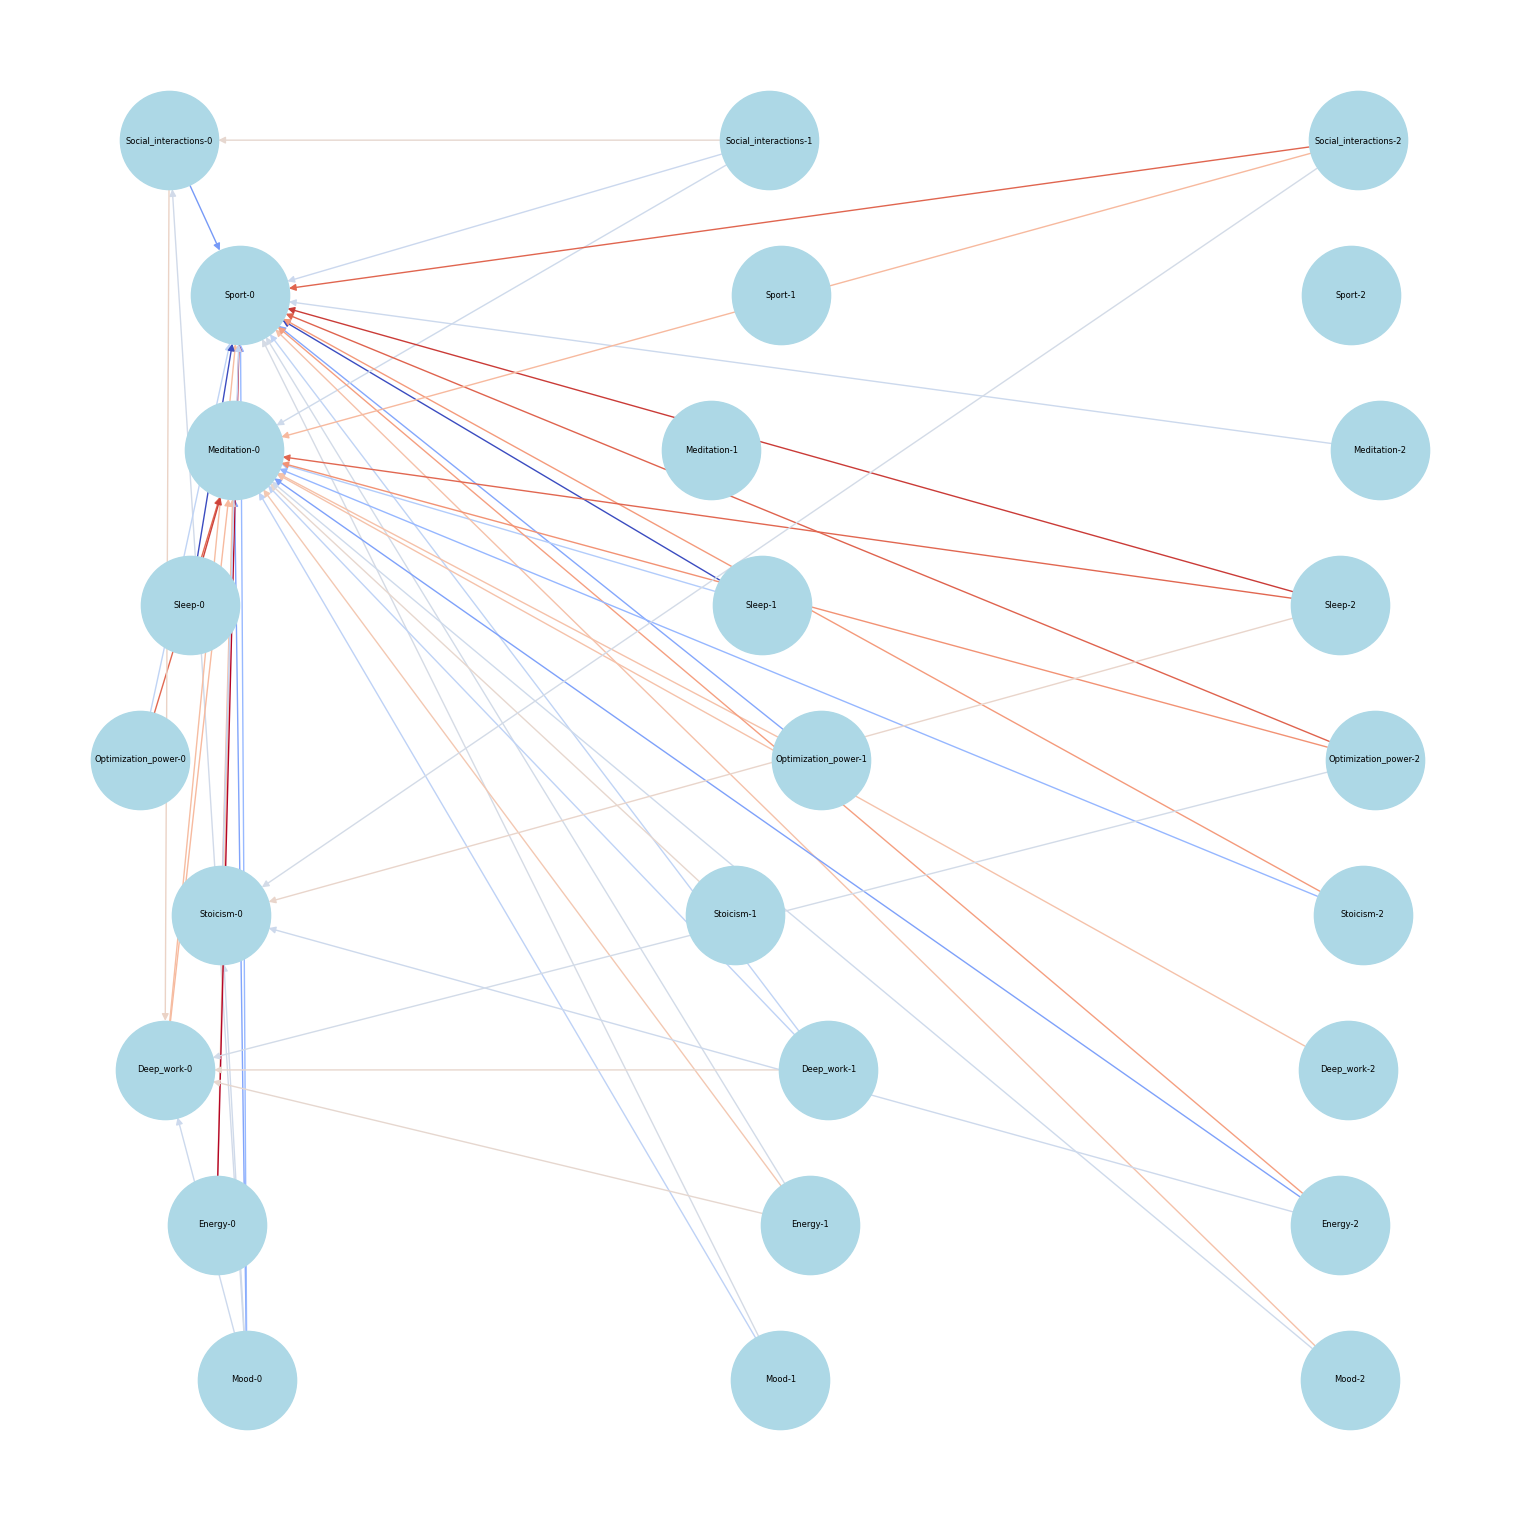

In [77]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


def number_to_color(number):
    cmap = plt.get_cmap("coolwarm")
    norm = mcolors.Normalize(vmin=-5, vmax=5)
    return cmap(norm(number))


G = nx.DiGraph()

for name in names:
    G.add_node(name)

edge_colors = []
results = []
for i, row in enumerate(adj_matrix):
    for j, value in enumerate(row):
        if value and (i, j) not in exclude_edges:
            color = number_to_color(value)
            if "0" in [names[i][-1], names[j][-1]]:
                results.append((names[i], names[j], value))
                edge_colors.append(color)
                G.add_edge(names[i], names[j])
results.sort()
print(*results, sep="\n")
pos = {}
for name in names:
    _, n = name.split("-")
    x = int(n)
    y = sum(round(pos_x) == x for (pos_x, _) in pos.values())
    x += np.random.normal(scale=0.05)
    pos[name] = (x, y)

plt.figure(figsize=(15, 15))
nx.draw(
    G,
    pos=pos,
    with_labels=True,
    node_color="lightblue",
    font_size=6,
    node_size=5000,
    edge_color=edge_colors,
)
# plt.show()
plt.savefig("dag.pdf")